In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

## Tensorboard setup

In [3]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter("runs/transfer_learning")

## 设置transform, 用于对数据进行转换

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

## 加载训练集和测试集，同时进行shuffle, batch_size, transform等设置

In [5]:
data_dir = "data/hymenoptera_data"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                         data_transforms[x]) 
                 for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) 
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 训练集图片可视化

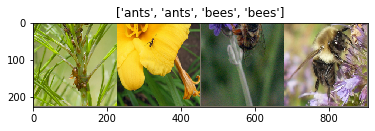

In [6]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## 封装训练模型函数，其中要注意的点是网络中存在batchnorm，所以在训练的时候model要处于training，推理的时候model要处于eval

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print("-" * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

## 利用训练好的模型进行推理预测，并可视化

In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                # 这里用于imshow的图片记得传送到CPU设备上
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## 定义网络结构

In [9]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 2)

inputs = torch.ones([1, 3, 224, 224], dtype=torch.float32)

writer.add_graph(model_ft, inputs)
writer.close()

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                      num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6312 Acc: 0.6762
val Loss: 0.1953 Acc: 0.9216

Epoch 1/24
----------
train Loss: 0.4758 Acc: 0.8320
val Loss: 0.2253 Acc: 0.9085

Epoch 2/24
----------
train Loss: 0.4872 Acc: 0.7623
val Loss: 0.1819 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.4790 Acc: 0.8074
val Loss: 0.3073 Acc: 0.8693

Epoch 4/24
----------
train Loss: 0.5559 Acc: 0.8074
val Loss: 0.2429 Acc: 0.8889

Epoch 5/24
----------
train Loss: 0.4294 Acc: 0.8279
val Loss: 0.3965 Acc: 0.8627

Epoch 6/24
----------
train Loss: 0.4419 Acc: 0.8361
val Loss: 0.7368 Acc: 0.7778

Epoch 7/24
----------
train Loss: 0.4016 Acc: 0.8320
val Loss: 0.3533 Acc: 0.8627

Epoch 8/24
----------
train Loss: 0.3086 Acc: 0.8730
val Loss: 0.3111 Acc: 0.8627

Epoch 9/24
----------
train Loss: 0.3970 Acc: 0.8279
val Loss: 0.3079 Acc: 0.8889

Epoch 10/24
----------
train Loss: 0.3880 Acc: 0.8279
val Loss: 0.2940 Acc: 0.8954

Epoch 11/24
----------
train Loss: 0.2853 Acc: 0.8648
val Loss: 0.2688 Acc: 0.8954

Ep

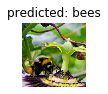

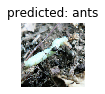

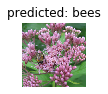

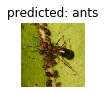

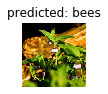

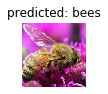

In [11]:
visualize_model(model_ft)

## 定义网络结构，不同的是，这里把特征提取层freeze了，也就是在训练的时候参数是不更新的

In [12]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [13]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5925 Acc: 0.6885
val Loss: 0.2965 Acc: 0.8889

Epoch 1/24
----------
train Loss: 0.4769 Acc: 0.7582
val Loss: 0.3010 Acc: 0.8954

Epoch 2/24
----------
train Loss: 0.4709 Acc: 0.8115
val Loss: 0.2655 Acc: 0.9150

Epoch 3/24
----------
train Loss: 0.4264 Acc: 0.7992
val Loss: 0.1848 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.4278 Acc: 0.8033
val Loss: 0.2012 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.4692 Acc: 0.7705
val Loss: 0.1733 Acc: 0.9542

Epoch 6/24
----------
train Loss: 0.4598 Acc: 0.7951
val Loss: 0.3588 Acc: 0.8627

Epoch 7/24
----------
train Loss: 0.4103 Acc: 0.8115
val Loss: 0.1665 Acc: 0.9608

Epoch 8/24
----------
train Loss: 0.2940 Acc: 0.8852
val Loss: 0.1636 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3685 Acc: 0.8525
val Loss: 0.1912 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3843 Acc: 0.8197
val Loss: 0.2023 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3775 Acc: 0.8566
val Loss: 0.1822 Acc: 0.9542

Ep

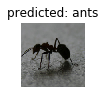

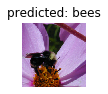

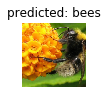

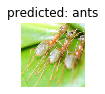

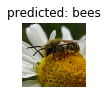

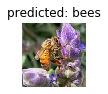

In [14]:
visualize_model(model_conv)

plt.ioff()
plt.show()

## 对比可以发现，freeze特征提取层之后，模型训练的参数量少了，训练的速度更快了